### Install Detectron2 Dependencies

1. PyYAML 5.1
2. Pytorch 1.7.1
3. Pytorch Vision 0.8.2
4. OpenCV (Not required to download in Google Colab)
5. Detectron2 (via direct link)

#### Notes:
1. Shell commands require "!" in the beginning for google colab. i.e. !pip



In [1]:
!pip install pyyaml==5.1

# Google Colab preinstalls torch==1.9.0 hence using a older version that
# detectron2 supports

# Torchvision version must match torch version for compatibity. See table on 
# the link below
# https://github.com/pytorch/vision#installation
!pip install torch==1.8.1+cu102 torchvision==0.9.1+cu102 -f https://download.pytorch.org/whl/torch_stable.html

# Install Detectron2 from pip. Using `-f` flag to fetch a precompiled detectron2 from a link
!pip install detectron2==0.4 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.8/index.html
# OR
#!pip install 'git+https://github.com/facebookresearch/detectron2.git'

     |████████████████████████████████| 276kB 6.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44091 sha256=c77111d2741803f60997d87bd174ff7e7537b9f9fd8e3df8778d63168aa16cf4
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 804.1MB 22kB/s 
     |████████████████████████████████| 17.3MB 192kB/s 
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.8.1+cu102 which is incompatible.
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Succes

In [1]:
import torch, torchvision
import cv2
# Make sure CUDA GPU is attached in the Colab
!nvidia-smi

print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.8")
print(cv2.__version__)

Wed Jun 23 18:42:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
# For Tensorboard (Easy Graphs)
setup_logger()

import numpy as np
import os, json, random

import sys
INSIDE_COLAB = 'google.colab' in sys.modules

if INSIDE_COLAB:
    # google.colab is not found in local python installation hence this is
    # inside IF so no error is thrown when running locally

    # cv2.imshow crashes in google colab hence using a google colab patch

    from google.colab.patches import cv2_imshow 
    print("Inside Google Colab")
    



# detectron2 imports
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode


"""
Call this function when outputting the image. Handles colab quirks for
outputting an image

"""
def handle_cv2imshow(img):
    if INSIDE_COLAB:
        cv2_imshow(img)
    else:
        cv2.imshow("ImageWindow", img)
        cv2.waitKey(0)



Inside Google Colab


In [3]:
# Get the Red Pepper Dataset
# Moved to Gist/Github because could not install directly from given link **https://seafile.zfn.uni-bremen.de/d/95ff067e6cce4055b825/**
!wget -O paprika.zip https://github.com/SijanNeupane49/PaprikaClassification/blob/6c73881a57fea4602b130c779f0c5ccebeecf3f2/paprika.zip?raw=true
!unzip -o paprika.zip > /dev/null # doesn't print log to console

--2021-06-23 18:42:18--  https://github.com/SijanNeupane49/PaprikaClassification/blob/6c73881a57fea4602b130c779f0c5ccebeecf3f2/paprika.zip?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/SijanNeupane49/PaprikaClassification/raw/6c73881a57fea4602b130c779f0c5ccebeecf3f2/paprika.zip [following]
--2021-06-23 18:42:19--  https://github.com/SijanNeupane49/PaprikaClassification/raw/6c73881a57fea4602b130c779f0c5ccebeecf3f2/paprika.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SijanNeupane49/PaprikaClassification/6c73881a57fea4602b130c779f0c5ccebeecf3f2/paprika.zip [following]
--2021-06-23 18:42:19--  https://raw.githubusercontent.com/SijanNeupane49/PaprikaClassification/6c73881a57fea4602b130c779f0c5ccebeecf3f2/paprika.zip
Resolving raw.git

#### Preparing the data for training

In [4]:
def get_paprika_dicts(img_dir):
  #this function is to transform datasets from annontation to detectron2 datasets
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f) #converts to python dictionary
 


    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
      #this 'for' loop takes all the annotation from the VIA file 
      #and stores it in record
      
        record = {}
 #      {
	# 	"filename": "1 (1).jpg",
	# 	"size": 28491,
	# 	"regions": [{
	# 		"shape_attributes": {
	# 			"name": "polygon",
	# 			"all_points_x": [551, 561, 565, 564, 561, 546, 535, 524, 508, 498, 484, 471, 468, 459, 445, 431, 418, 409, 401, 385, 375, 365, 361, 359, 360, 353, 343, 340, 341, 347, 357, 365, 369, 372, 383, 396, 410, 418, 431, 437, 447, 460, 473, 483, 494, 500, 513, 531, 546, 553],
	# 			"all_points_y": [245, 235, 220, 201, 187, 168, 158, 143, 130, 125, 122, 125, 128, 125, 121, 121, 124, 131, 133, 143, 151, 165, 176, 187, 193, 199, 212, 223, 239, 257, 267, 275, 283, 293, 307, 314, 321, 321, 321, 322, 319, 323, 328, 332, 339, 340, 331, 319, 305, 286]
	# 		},
	# 		"region_attributes": {}
	# 	}],
	# 	"file_attributes": {}
	# }
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        print(cv2.imread(filename).shape)

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width


        annos = v["regions"] 
        #annotations,annotations are saved in regions in VIA
        objs = []
        # for _, anno in annos.items():
        for anno in annos:
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                # Create a bounding box around the segmented pepper
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                # Extract Segmentation of where the pepper is
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    #datasets folder name for training and validation sets
    DatasetCatalog.register("paprika_" + d, lambda d=d: get_paprika_dicts("Paprika/" + d))
    MetadataCatalog.get("paprika_" + d).set(thing_classes=["paprika"])
    #separate classes

paprika_metadata = MetadataCatalog.get("paprika_train")

#### Visualize some training dataset

In [5]:
def visuallize_image(d):
    # 'd' === one annotation in the via file
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=paprika_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    handle_cv2imshow(out.get_image()[:, :, ::-1])

(480, 852, 3)
(480, 852, 3)
(1117, 1900, 3)
(1357, 1900, 3)
(335, 670, 3)
(410, 600, 3)
(480, 600, 3)
(810, 720, 3)
(280, 280, 3)
(742, 1200, 3)
(1080, 810, 3)
(400, 600, 3)
(550, 550, 3)
(1196, 858, 3)
(425, 500, 3)
(750, 750, 3)
(640, 640, 3)
(606, 606, 3)
(640, 640, 3)
(681, 1024, 3)
(375, 500, 3)
(833, 1024, 3)
(763, 1024, 3)
(683, 1024, 3)
(1024, 683, 3)
(738, 1024, 3)
(2048, 1365, 3)
(1356, 2047, 3)
(554, 900, 3)
(450, 600, 3)
(1382, 2048, 3)
(450, 600, 3)
(2048, 1536, 3)
(1365, 2047, 3)
(1067, 1600, 3)
(1367, 2048, 3)
(1365, 2048, 3)
(1365, 2048, 3)
(640, 640, 3)
(375, 500, 3)
(700, 700, 3)
(1000, 1500, 3)
(682, 1024, 3)
(720, 960, 3)
(700, 700, 3)
(800, 600, 3)
(2687, 3357, 3)
(1000, 1000, 3)
(837, 600, 3)
(500, 500, 3)
(1440, 2560, 3)
(480, 960, 3)
(840, 1400, 3)
(498, 500, 3)
(1067, 1600, 3)
(541, 812, 3)
(1024, 1024, 3)
(454, 633, 3)
(905, 1024, 3)
(1200, 800, 3)
(640, 572, 3)
(640, 960, 3)
(540, 960, 3)
(640, 960, 3)
(1020, 1920, 3)
(1700, 2400, 3)
(323, 450, 3)
(337, 500, 

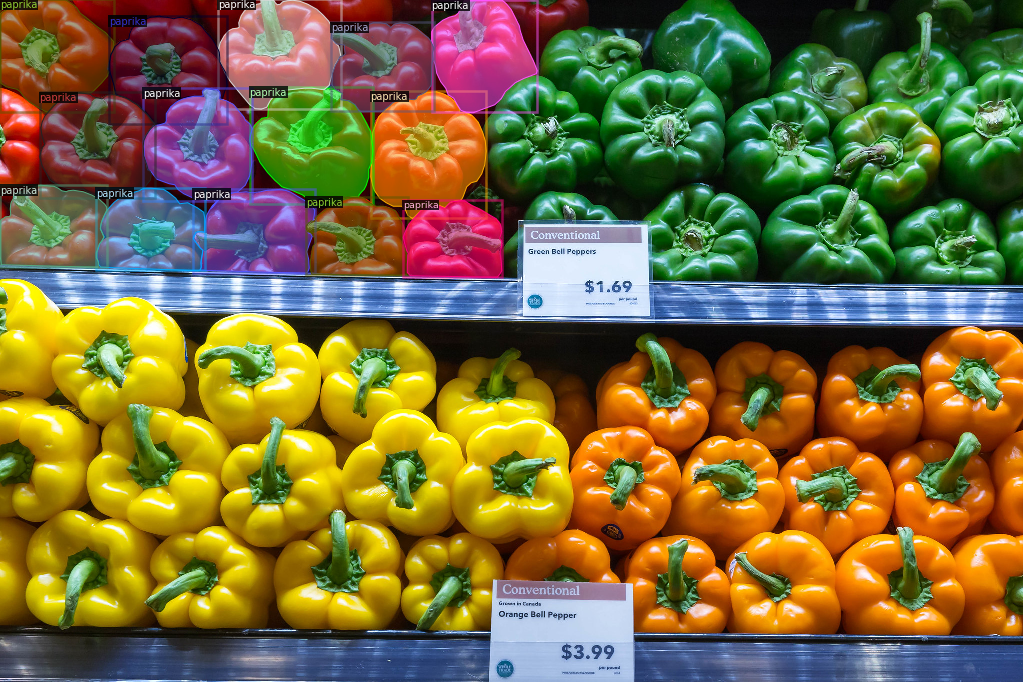

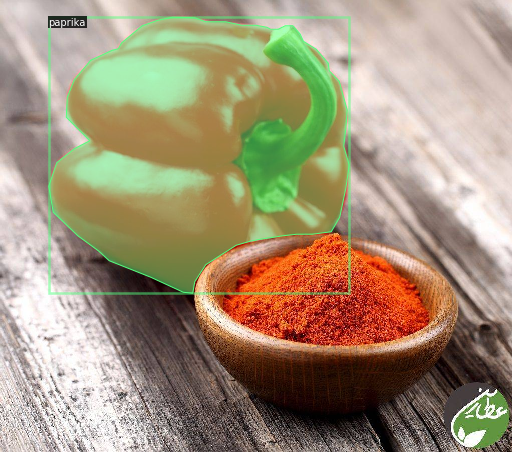

In [6]:
dataset_dicts = get_paprika_dicts("Paprika/train")

for d in random.sample(dataset_dicts, 2):
    # View Some Annomtated Image Images to check if they have been annotated
    # properly
    visuallize_image(d)

#### Setup configration for training at dataset

In [11]:
def train(dataset_name):
    cfg = get_cfg()
        
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) # Get initial configuration from model zoo
    cfg.DATASETS.TRAIN = (dataset_name,)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.0100  # pick a good LR # learing rate was 0.01,0.02, 0.00025
    cfg.SOLVER.MAX_ITER =1500    # 500,1000,300 was before, and 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
    cfg.SOLVER.STEPS = []        # do not decay learning rate
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (paprika). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
    # NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()

    return cfg

#### Train and update the configuration with the trained model

In [12]:
cfg = train("paprika_train")

def update_configuration(cfg):
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
    return cfg

cfg = update_configuration(cfg)

[06/23 19:07:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[06/23 19:07:44 d2.engine.train_loop]: Starting training from iteration 0
[06/23 19:07:53 d2.utils.events]:  eta: 0:10:35  iter: 19  total_loss: 1.983  loss_cls: 0.5396  loss_box_reg: 0.7189  loss_mask: 0.6506  loss_rpn_cls: 0.009718  loss_rpn_loc: 0.006573  time: 0.4395  data_time: 0.0219  lr: 0.00019981  max_mem: 2758M
[06/23 19:08:03 d2.utils.events]:  eta: 0:11:29  iter: 39  total_loss: 1.286  loss_cls: 0.2693  loss_box_reg: 0.5688  loss_mask: 0.3415  loss_rpn_cls: 0.00627  loss_rpn_loc: 0.003267  time: 0.4544  data_time: 0.0137  lr: 0.00039961  max_mem: 2845M
[06/23 19:08:11 d2.utils.events]:  eta: 0:11:08  iter: 59  total_loss: 0.7076  loss_cls: 0.1476  loss_box_reg: 0.4359  loss_mask: 0.1048  loss_rpn_cls: 0.001291  loss_rpn_loc: 0.005061  time: 0.4493  data_time: 0.0080  lr: 0.00059941  max_mem: 2845M
[06/23 19:08:20 d2.utils.events]:  eta: 0:10:48  iter: 79  total_loss: 0.5033  loss_cls: 0.1131  loss_box_reg: 0.2615  loss_mask: 0.07506  loss_rpn_cls: 0.003245  loss_rpn_loc: 0.

#### Setup Predictor and Prediction Visualization

In [13]:
def visuallize_prediction(predictor, d):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=paprika_metadata, 
                   scale=0.5,
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])


(350, 610, 3)
(911, 1240, 3)
(500, 500, 3)
(835, 1021, 3)
(1152, 2048, 3)
(850, 1332, 3)
(2772, 3569, 3)
(1024, 1024, 3)
(853, 1280, 3)
(1200, 1800, 3)
(310, 480, 3)
(640, 960, 3)
(623, 900, 3)
(1280, 1920, 3)
(1080, 1440, 3)


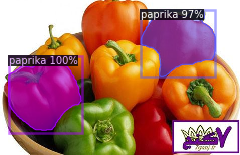

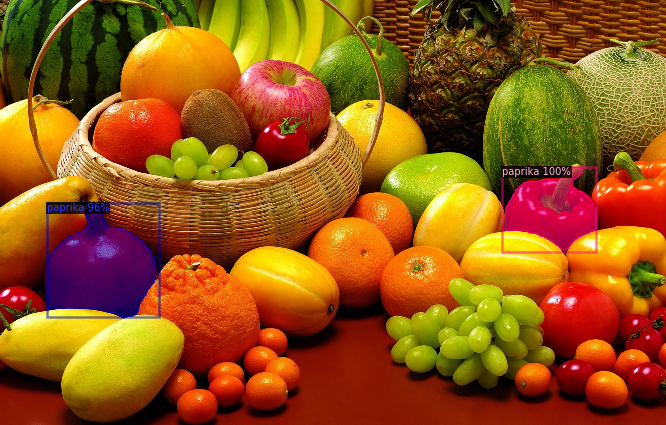

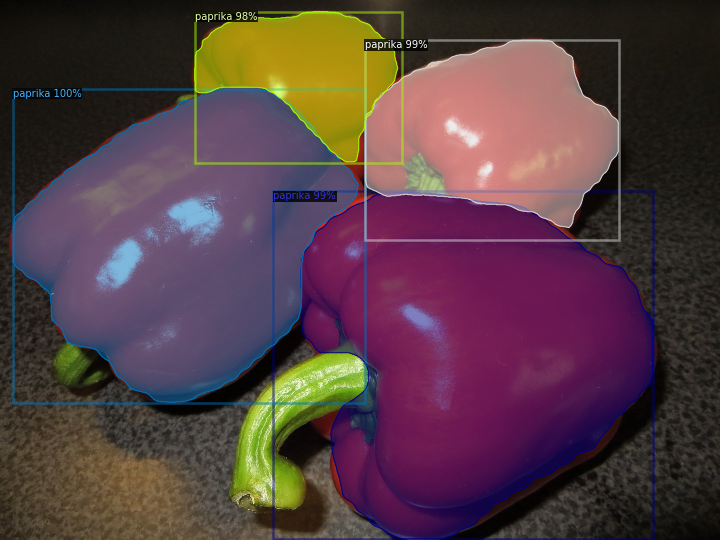

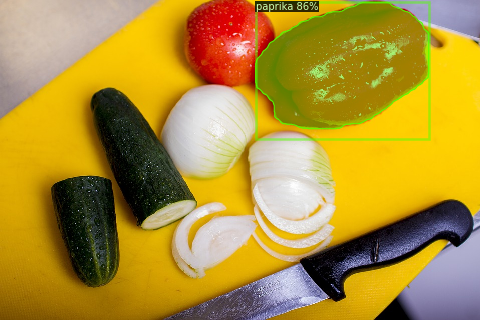

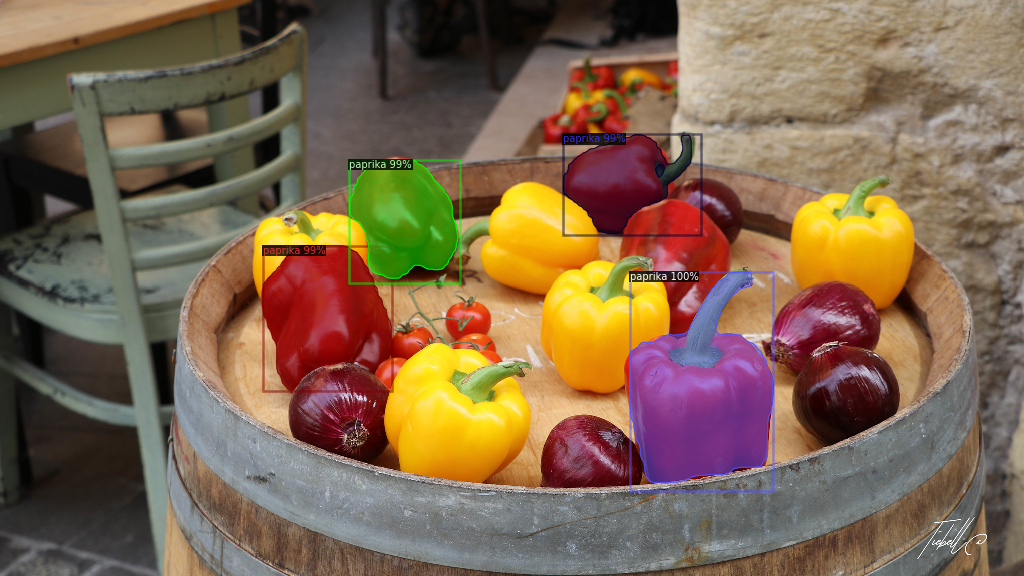

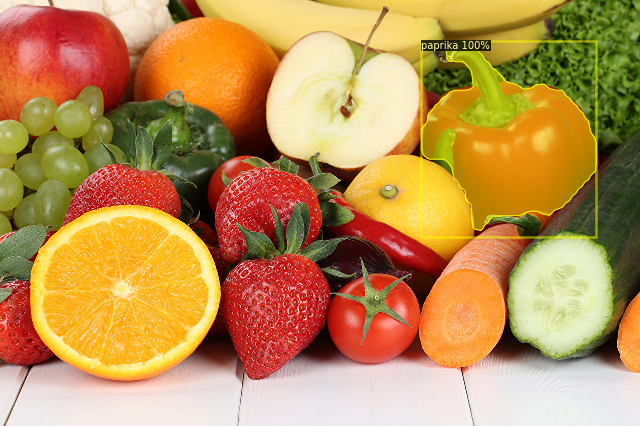

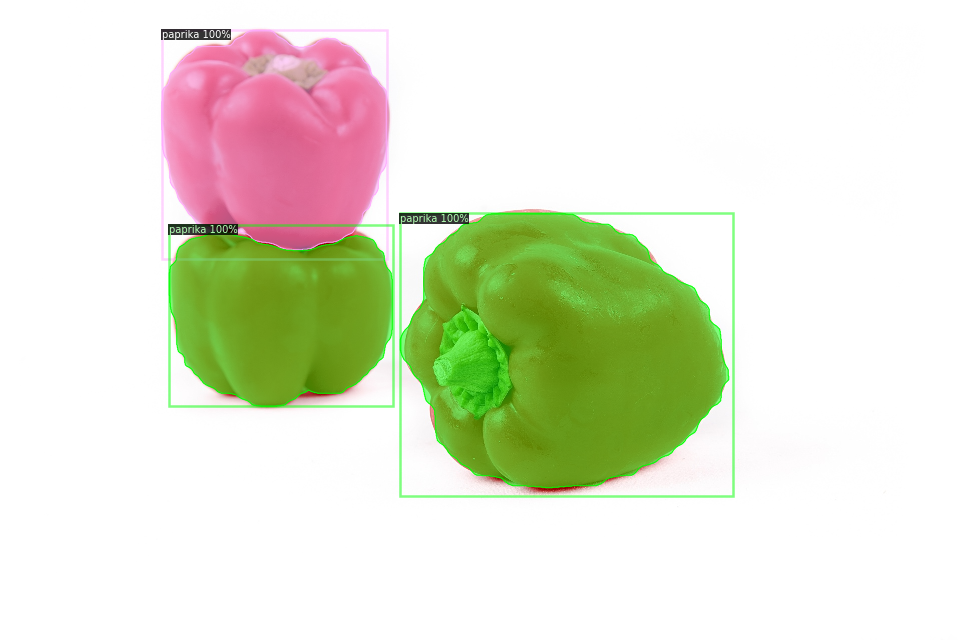

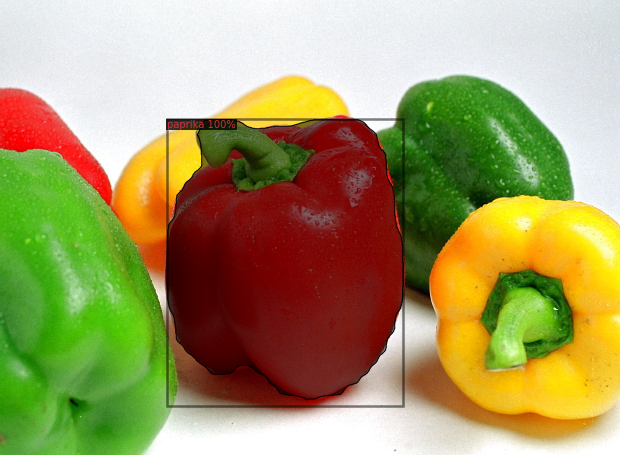

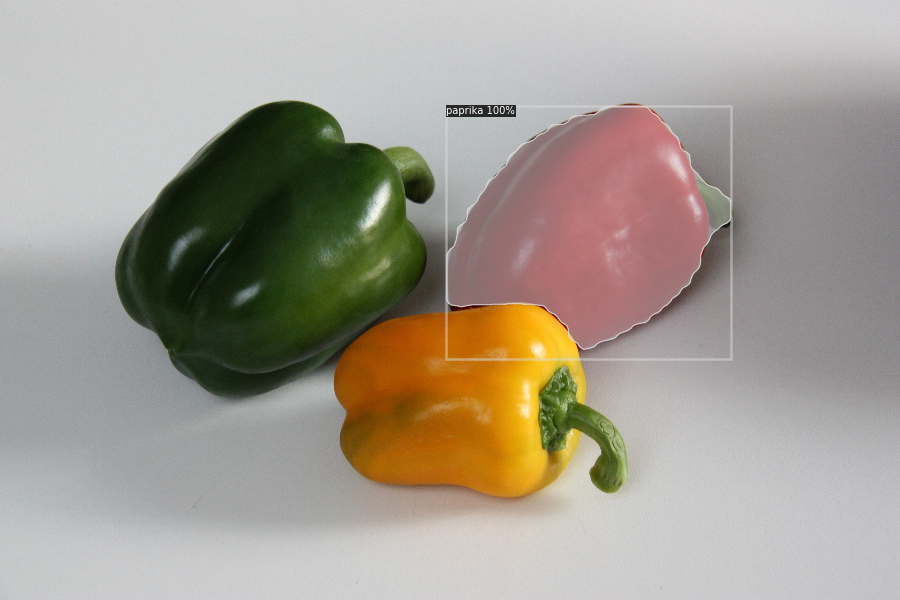

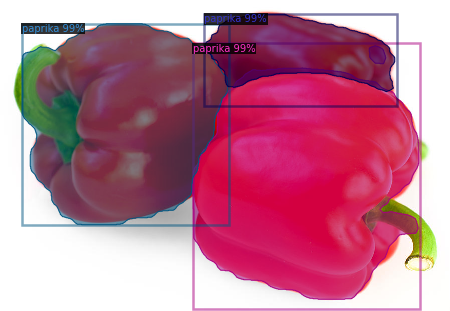

In [14]:
predictor = DefaultPredictor(cfg)

dataset_dicts = get_paprika_dicts("Paprika/val")

for d in random.sample(dataset_dicts, 10):
    visuallize_prediction(predictor, d)

In [21]:
# Look at training curves in tensorboard:
!kill 554
%reload_ext tensorboard
%tensorboard --logdir output

/bin/bash: line 0: kill: (554) - No such process


Reusing TensorBoard on port 6006 (pid 585), started 0:00:38 ago. (Use '!kill 585' to kill it.)

<IPython.core.display.Javascript object>